In [6]:
%run clean_data_en_lstm
%run clean_features

In [7]:
from collections import defaultdict, namedtuple
import numpy as np
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import duolingo_replica_alex as dr
import duolingo_replica as d
import dask.dataframe as dd

In [8]:
file_path = "C:/Users/Alexander/Dropbox/halflife_regression_rl/0_data/learning_traces.13m.csv"
result_df_en_top20 = process_data(file_path, 20)
result_df_en_top20

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,appearance_count
0,1.0,1362082504,357,u:dwbJ,en,pt,1052c3ace653dbc8923eaa183bc02b88,definition/definition<n><sg>,17,17,2,2,629
1,1.0,1362082504,357,u:dwbJ,en,pt,9cba1b30f88bf3c047b22cffcaf88c12,surface/surface<n><sg>,19,19,3,3,629
2,1.0,1362082504,357,u:dwbJ,en,pt,961cd149f20f2571419b1412d849f19a,scale/scale<n><sg>,21,20,3,3,629
3,0.8,1362082504,357,u:dwbJ,en,pt,5cbb1249562e95794a4c4ae0e2d8ae26,temperature/temperature<n><sg>,44,36,5,4,629
4,1.0,1362082504,357,u:dwbJ,en,pt,2df65bdf80d10d2b78d62cb2e0a731d8,distance/distance<n><sg>,21,20,3,3,629
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569115,1.0,1363104881,4294673,u:f_W4,en,pt,c032182c0ffb744c963ec83c937a26f4,us/prpers<prn><obj><p1><mf><pl>,10,9,1,1,35
569116,1.0,1363104881,4666611,u:f_W4,en,pt,80765ae2a08ba6812a4ab9df607b97d2,am/be<vbser><pri><p1><sg>,21,19,1,1,35
569117,0.5,1363104881,3543733,u:f_W4,en,pt,6d4c572af8022cb4784ce0f8898d1905,to/to<pr>,4,4,2,1,35
569118,1.0,1363104881,3610474,u:f_W4,en,pt,c9fb923e49d5cba24b5afb9ee1cff2a9,wine/wine<n><sg>,21,18,1,1,35


In [9]:
# def read_data( df, omit_lexemes = False  ):
    
#     min_hl = 15.0 / ( 24 * 60 )
#     max_hl = 274. 
    
#     df[ 'p' ]          = df[ 'p_recall' ].apply( lambda x: np.clip( float( x ),  0.0001, .9999 ) )
#     df[ 't' ]          = df[ 'delta' ].apply( lambda x: float( x ) / ( 60 * 60 * 24 ) )
#     df[ 'h' ]          = df.apply( lambda row: np.clip( -row[ 't' ] / np.log2( row [ 'p' ] ), min_hl, max_hl ), axis = 1 )
#     df[ 'lang' ]       = df.apply( lambda row: f"{ row[ 'ui_language' ] } -> { row[ 'learning_language' ] }", axis = 1 )
#     df[ 'lexeme' ]     = df.apply( lambda row: f"{ row[ 'learning_language' ] }:{ row[ 'lexeme_string' ] }", axis = 1 )
#     df[ 'right' ]      = df[ 'history_correct' ].astype( int )
#     df[ 'wrong' ]      = df[ 'history_seen' ].astype( int ) - df[ 'right' ]    
#     df[ 'right_this' ] = df[ 'session_correct' ].astype( int )
#     df[ 'wrong_this' ] = df[ 'session_seen' ].astype( int ) - df[ 'right_this' ]  
#     df[ 'right' ]      = df[ 'right' ].apply( lambda x: np.sqrt( 1 + x ) )
#     df[ 'wrong' ]      = df[ 'wrong' ].apply( lambda x: np.sqrt( 1 + x ) )
#     df[ 'bias' ]       = 1
    
#     # Seconds to date
#     df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    
#     # Function to convert time to decimal hours
#     def time_to_decimal(time):
#         return time.hour + time.minute / 60 + time.second / 3600

#     # Apply the function to the 'datetime' column
#     df['decimal_hours'] = df['datetime'].apply(lambda x: time_to_decimal(x))
    
#     # create the year var
#     df['date_only'] = pd.to_datetime(df['datetime']).dt.date

#     if not omit_lexemes:
    
#         lexeme_dummies = pd.get_dummies( df[ 'lexeme' ], dtype = float )
#         lexeme_columns = lexeme_dummies.columns.to_list()
#         df = pd.concat( [ df, lexeme_dummies ], axis = 1 )
        
#         feature_vars = [ 'right', 'wrong', 'bias' ] + lexeme_columns
                         
#     else:
                         
#         feature_vars = [ 'right', 'wrong', 'bias' ]

#     def categorize_time_of_day(hour):
#         if 5 <= hour < 12:
#             return 'morning'
#         elif 12 <= hour < 17:
#             return 'afternoon'
#         elif 17 <= hour < 21:
#             return 'evening'
#         else:
#             return 'night'

#     # Apply the function to your DataFrame
#     df['time_of_day'] = df['decimal_hours'].apply(categorize_time_of_day)

#     # Get dummy variables
#     time_of_day_dummies = pd.get_dummies(df['time_of_day'], prefix='time')

#     # Join the dummies back to the original DataFrame or use them separately as needed
#     df = df.join(time_of_day_dummies)
    
# #     # Keep users either in training or testing
# #     grouped = df.groupby('user_id')
    
# #     # Create a list to store user IDs for training and testing
# #     train_users = []
# #     test_users = []

# #     for user_id in grouped.groups.keys():
# #         if np.random.rand() < 0.8:  # 80% chance
# #             train_users.append(user_id)
# #         else:
# #             test_users.append(user_id)

# #     trainset = df[df['user_id'].isin(train_users)]
# #     testset = df[df['user_id'].isin(test_users)]

# #     splitpoint = int(0.9 * len(df))
# #     trainset   = df[ : splitpoint ]
# #     testset    = df[ splitpoint : ]

#     return df, feature_vars

In [10]:
clean_data, feature_vars = read_data( result_df_en_top20, omit_lexemes = False )

In [14]:
clean_data

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,...,en:your/your<det><pos><sp>,en:yours/yours<prn><pos><mf><sp>,en:yourself/yourself<prn><ref><p2><mf><sg>,en:youth/youth<n><sg>,en:zone/zone<n><sg>,time_of_day,time_afternoon,time_evening,time_morning,time_night
0,1.0,1362082504,357,u:dwbJ,en,pt,1052c3ace653dbc8923eaa183bc02b88,definition/definition<n><sg>,17,17,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
1,1.0,1362082504,357,u:dwbJ,en,pt,9cba1b30f88bf3c047b22cffcaf88c12,surface/surface<n><sg>,19,19,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
2,1.0,1362082504,357,u:dwbJ,en,pt,961cd149f20f2571419b1412d849f19a,scale/scale<n><sg>,21,20,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
3,0.8,1362082504,357,u:dwbJ,en,pt,5cbb1249562e95794a4c4ae0e2d8ae26,temperature/temperature<n><sg>,44,36,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
4,1.0,1362082504,357,u:dwbJ,en,pt,2df65bdf80d10d2b78d62cb2e0a731d8,distance/distance<n><sg>,21,20,...,0.0,0.0,0.0,0.0,0.0,evening,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569115,1.0,1363104881,4294673,u:f_W4,en,pt,c032182c0ffb744c963ec83c937a26f4,us/prpers<prn><obj><p1><mf><pl>,10,9,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
569116,1.0,1363104881,4666611,u:f_W4,en,pt,80765ae2a08ba6812a4ab9df607b97d2,am/be<vbser><pri><p1><sg>,21,19,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
569117,0.5,1363104881,3543733,u:f_W4,en,pt,6d4c572af8022cb4784ce0f8898d1905,to/to<pr>,4,4,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
569118,1.0,1363104881,3610474,u:f_W4,en,pt,c9fb923e49d5cba24b5afb9ee1cff2a9,wine/wine<n><sg>,21,18,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0


In [15]:
feature_vars_time = feature_vars + ['time_afternoon', 'time_evening', 'time_morning', 'time_night']
print(feature_vars_time)

['right', 'wrong', 'bias', "en:'/'<apos>", "en:'s/'s<gen>", 'en:<*sf>/account<n><*numb>', 'en:<*sf>/action<n><*numb>', 'en:<*sf>/activity<n><*numb>', 'en:<*sf>/actor<n><*numb>', 'en:<*sf>/advantage<n><*numb>', 'en:<*sf>/adventure<n><*numb>', 'en:<*sf>/afternoon<n><*numb>', 'en:<*sf>/age<n><*numb>', 'en:<*sf>/answer<n><*numb>', 'en:<*sf>/area<n><*numb>', 'en:<*sf>/arm<n><*numb>', 'en:<*sf>/arrival<n><*numb>', 'en:<*sf>/article<n><*numb>', 'en:<*sf>/artist<n><*numb>', 'en:<*sf>/aspect<n><*numb>', 'en:<*sf>/attack<n><*numb>', 'en:<*sf>/attorney<n><*numb>', 'en:<*sf>/august<n><*numb>', 'en:<*sf>/aunt<n><*numb>', 'en:<*sf>/author<n><*numb>', 'en:<*sf>/authority<n><*numb>', 'en:<*sf>/baby<n><*numb>', 'en:<*sf>/basket<n><*numb>', 'en:<*sf>/bathroom<n><*numb>', 'en:<*sf>/battle<n><*numb>', 'en:<*sf>/beach<n><*numb>', 'en:<*sf>/beauty<n><*numb>', 'en:<*sf>/bed<n><*numb>', 'en:<*sf>/benefit<n><*numb>', 'en:<*sf>/bicycle<n><*numb>', 'en:<*sf>/birth<n><*numb>', 'en:<*sf>/boat<n><*numb>', 'en:<*sf>

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming clean_data is your DataFrame, Y is the target column, and feature_vars are the features
# Extract unique users
unique_users = clean_data['user_id'].unique()  # Replace 'user_id' with your user identifier column

# Split users into train and test groups
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Create training and testing datasets
train_data = clean_data[clean_data['user_id'].isin(train_users)]
test_data = clean_data[clean_data['user_id'].isin(test_users)]

In [17]:
# Pre-sort the data by 'user_id' and 'datetime'
train_data.sort_values(by=['user_id', 'datetime'], inplace= True)
test_data.sort_values(by=['user_id', 'datetime'], inplace= True)

c:\Users\Alexander\anaconda3\envs\tensorflow\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [18]:
train_data.user_id.nunique()
train_data.shape

(455280, 2325)

In [19]:
import pandas as pd

# Assuming 'train_data' is your DataFrame and it includes a column 'user_id' for user identifiers
# Count the number of periods for each user
user_period_counts = train_data['user_id'].value_counts()

# Display the distribution of the counts
user_period_distribution = user_period_counts.value_counts().sort_index()
print(user_period_distribution)

20    22764
Name: user_id, dtype: int64


<AxesSubplot:>

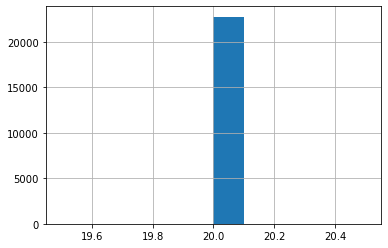

In [20]:
user_period_counts.hist()

## Create Batches so we cann run the model

In [22]:
import numpy as np

def create_non_overlapping_sequences(data, feature_vars, time_steps=20, batch_size=1000):
    # Convert feature columns to numpy for faster processing
    feature_data = data[feature_vars].to_numpy()
    output_data = data['p'].to_numpy()  # Assuming 'p' is your target variable

    # Get the starting index for each new user
    user_change_indices = np.where(data['user_id'].to_numpy()[:-1] != data['user_id'].to_numpy()[1:])[0] + 1
    user_start_indices = np.insert(user_change_indices, 0, 0)

    for batch_start in range(0, len(user_start_indices), batch_size):
        sequences = []
        outputs = []

        # Iterate through each user in the batch
        for i in range(batch_start, min(batch_start + batch_size, len(user_start_indices))):
            start_idx = user_start_indices[i]
            end_idx = start_idx + time_steps if i + 1 < len(user_start_indices) else len(feature_data)

            # Check if the user data is exactly equal to time_steps
            if end_idx - start_idx == time_steps:
                sequences.append(feature_data[start_idx:end_idx])
                outputs.append(output_data[end_idx - 1])  # Target for the last period in the sequence

        yield np.array(sequences), np.array(outputs)

# # Usage of the generator
# for X_batch, Y_batch in create_non_overlapping_sequences(train_data, feature_vars_time):
#     # Process each batch - e.g., train your model on each batch
#     pass


# LSTM BASE MODEL

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(20, len(feature_vars_time)), activation='relu'))  # Adjust units, activation
model.add(Dense(1))  # Output layer - adjust based on your problem
model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust optimizer, loss function as per your requirement

In [24]:
from tensorflow.keras.metrics import MeanAbsoluteError
import numpy as np

# Initialize the MAE metric
mae_metric = MeanAbsoluteError()
num_epochs = 20
# Train the model using the generator
for epoch in range(num_epochs):  # You can define the number of epochs
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    for X_batch, Y_batch in create_non_overlapping_sequences(train_data, feature_vars_time):
        # Train on batch and compute loss
        loss = model.train_on_batch(X_batch, Y_batch)

        # Compute MAE
        predictions = model.predict_on_batch(X_batch)
        mae_metric.update_state(Y_batch, predictions)
        mae = mae_metric.result().numpy()  # Get the MAE value

        # Reset MAE metric at the end of each batch
        mae_metric.reset_states()

        # Optionally print the loss and MAE for each batch
        print("Batch Loss: {:.4f}, Batch MAE: {:.4f}".format(loss, mae))


Epoch 1/20
Batch Loss: 0.9211, Batch MAE: 0.8441
Batch Loss: 0.7726, Batch MAE: 0.7786
Batch Loss: 0.6496, Batch MAE: 0.7127
Batch Loss: 0.5474, Batch MAE: 0.6521
Batch Loss: 0.4594, Batch MAE: 0.5893
Batch Loss: 0.3635, Batch MAE: 0.5145
Batch Loss: 0.2837, Batch MAE: 0.4397
Batch Loss: 0.2248, Batch MAE: 0.3678
Batch Loss: 0.1626, Batch MAE: 0.3048


KeyboardInterrupt: 

In [76]:
# Initialize metric for testing
test_mae_metric = MeanAbsoluteError()

# Run model on test data
for X_test_batch, Y_test_batch in create_non_overlapping_sequences(test_data, feature_vars_time):
    # Make predictions
    test_predictions = model.predict_on_batch(X_test_batch)

    # Update MAE metric
    test_mae_metric.update_state(Y_test_batch, test_predictions)
    print(test_mae_metric.result())

# Calculate final MAE on test data
final_test_mae = test_mae_metric.result().numpy()
print("Final Test MAE: {:.6f}".format(final_test_mae))

tf.Tensor(0.15451026, shape=(), dtype=float32)
tf.Tensor(0.15258828, shape=(), dtype=float32)
tf.Tensor(0.15558596, shape=(), dtype=float32)
tf.Tensor(0.1547046, shape=(), dtype=float32)
tf.Tensor(0.15569694, shape=(), dtype=float32)
tf.Tensor(0.1562008, shape=(), dtype=float32)
Final Test MAE: 0.156201


# Complex Model

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

model = Sequential()
model.add(LSTM(100, input_shape=(20, len(feature_vars_time)), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(1, kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
from tensorflow.keras.metrics import MeanAbsoluteError
import numpy as np

# Initialize the MAE metric
mae_metric = MeanAbsoluteError()
num_epochs = 20
# Train the model using the generator
for epoch in range(num_epochs):  # You can define the number of epochs
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    for X_batch, Y_batch in create_non_overlapping_sequences(train_data, feature_vars_time):
        # Train on batch and compute loss
        loss = model.train_on_batch(X_batch, Y_batch)

        # Compute MAE
        predictions = model.predict_on_batch(X_batch)
        mae_metric.update_state(Y_batch, predictions)
        mae = mae_metric.result().numpy()  # Get the MAE value

        # Reset MAE metric at the end of each batch
        mae_metric.reset_states()

        # Optionally print the loss and MAE for each batch
        print("Batch Loss: {:.4f}, Batch MAE: {:.4f}".format(loss, mae))

In [80]:
train_data

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,...,en:your/your<det><pos><sp>,en:yours/yours<prn><pos><mf><sp>,en:yourself/yourself<prn><ref><p2><mf><sg>,en:youth/youth<n><sg>,en:zone/zone<n><sg>,time_of_day,time_afternoon,time_evening,time_morning,time_night
393760,1.0,1362605060,1393329,u:-AA,en,es,17632879145d3e2737d11a3a5053dd50,his/his<det><pos><sp>,4,4,...,0.0,0.0,0.0,0.0,0.0,night,0,0,0,1
393761,0.5,1362605060,1393329,u:-AA,en,es,be2ec2c393a6049b9e1928af32c3cf08,your/your<det><pos><sp>,5,5,...,1.0,0.0,0.0,0.0,0.0,night,0,0,0,1
393762,1.0,1362605060,1393329,u:-AA,en,es,5e56b2dcc7cdc8f6cd58854622b45643,her/her<det><pos><sp>,6,5,...,0.0,0.0,0.0,0.0,0.0,night,0,0,0,1
393763,0.5,1362605060,1393329,u:-AA,en,es,4e6eee1689a883a483fe26c82d14e8c9,their/their<det><pos><sp>,7,5,...,0.0,0.0,0.0,0.0,0.0,night,0,0,0,1
393764,1.0,1362605060,1393329,u:-AA,en,es,2b97dce464f0a69324ffd2955a7eff1f,our/our<det><pos><sp>,7,6,...,0.0,0.0,0.0,0.0,0.0,night,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566555,0.0,1363097622,7901657,u:zwG,en,es,1f52d650da1ee41e47ee11caf853e6f4,sandwich/sandwich<n><sg>,9,5,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
566556,1.0,1363097622,7901446,u:zwG,en,es,842443fda40da053ff7f8d68c1af99b8,oil/oil<n><sg>,6,6,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
566557,1.0,1363097622,7901446,u:zwG,en,es,f19bad09b7354d4cf02403544519d849,dinner/dinner<n><sg>,6,5,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0
566558,0.5,1363097622,7901657,u:zwG,en,es,a826c47947d68549fa81e19cafa57ba0,eat/eat<vblex><pres>,15,12,...,0.0,0.0,0.0,0.0,0.0,afternoon,1,0,0,0


In [ ]:
# Initialize metric for testing
test_mae_metric = MeanAbsoluteError()

# Run model on test data
for X_test_batch, Y_test_batch in create_non_overlapping_sequences(test_data, feature_vars_time):
    # Make predictions
    test_predictions = model.predict_on_batch(X_test_batch)

    # Update MAE metric
    test_mae_metric.update_state(Y_test_batch, test_predictions)
    print(test_mae_metric.result())

# Calculate final MAE on test data
final_test_mae = test_mae_metric.result().numpy()
print("Final Test MAE: {:.6f}".format(final_test_mae))

In [78]:
# Train dataset
y_train = train_data["p"]
X_train = train_data[feature_vars_time]
X_train["delta"] = train_data["t"]

# Test dataset
y_test = test_data["p"]
X_test = test_data[feature_vars_time]
X_test["delta"] = test_data["t"]

C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_26412/917030861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["delta"] = train_data["t"]
C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_26412/917030861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["delta"] = test_data["t"]


# NN Basic Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have preprocessed your data into X (features) and y (target)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Adjust input_shape based on number of features
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Fit the model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)  # Adjust these parameters as needed

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

Epoch 1/200
12805/12805 [==============================] - 14s 1ms/step - loss: 0.0694 - mae: 0.1704 - val_loss: 0.0561 - val_mae: 0.1438
Epoch 2/200
12805/12805 [==============================] - 12s 970us/step - loss: 0.0642 - mae: 0.1644 - val_loss: 0.0551 - val_mae: 0.1460
Epoch 3/200
12805/12805 [==============================] - 12s 953us/step - loss: 0.0637 - mae: 0.1637 - val_loss: 0.0550 - val_mae: 0.1488
Epoch 4/200
12805/12805 [==============================] - 12s 962us/step - loss: 0.0635 - mae: 0.1635 - val_loss: 0.0552 - val_mae: 0.1609
Epoch 5/200
12805/12805 [==============================] - 13s 994us/step - loss: 0.0634 - mae: 0.1632 - val_loss: 0.0550 - val_mae: 0.1534
Epoch 6/200
12805/12805 [==============================] - 12s 936us/step - loss: 0.0633 - mae: 0.1631 - val_loss: 0.0551 - val_mae: 0.1543
Epoch 7/200
12805/12805 [==============================] - 12s 940us/step - loss: 0.0633 - mae: 0.1630 - val_loss: 0.0552 - val_mae: 0.1441
Epoch 8/200
12805/1280

12805/12805 [==============================] - 12s 953us/step - loss: 0.0629 - mae: 0.1619 - val_loss: 0.0554 - val_mae: 0.1497
Epoch 60/200
12805/12805 [==============================] - 13s 999us/step - loss: 0.0629 - mae: 0.1619 - val_loss: 0.0555 - val_mae: 0.1517
Epoch 61/200
12805/12805 [==============================] - 14s 1ms/step - loss: 0.0628 - mae: 0.1619 - val_loss: 0.0554 - val_mae: 0.1495
Epoch 62/200
12805/12805 [==============================] - 12s 956us/step - loss: 0.0629 - mae: 0.1619 - val_loss: 0.0554 - val_mae: 0.1614
Epoch 63/200
12805/12805 [==============================] - 12s 916us/step - loss: 0.0628 - mae: 0.1619 - val_loss: 0.0556 - val_mae: 0.1603
Epoch 64/200
12805/12805 [==============================] - 12s 927us/step - loss: 0.0628 - mae: 0.1619 - val_loss: 0.0554 - val_mae: 0.1545
Epoch 65/200
12805/12805 [==============================] - 12s 971us/step - loss: 0.0628 - mae: 0.1619 - val_loss: 0.0553 - val_mae: 0.1524
Epoch 66/200
12805/12805 [==

## NN Complex Model

In [79]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)

loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

Epoch 1/200
12805/12805 [==============================] - 27s 2ms/step - loss: 0.0747 - mae: 0.1798 - val_loss: 0.0554 - val_mae: 0.1438
Epoch 2/200
12805/12805 [==============================] - 25s 2ms/step - loss: 0.0642 - mae: 0.1651 - val_loss: 0.0551 - val_mae: 0.1523
Epoch 3/200
12805/12805 [==============================] - 25s 2ms/step - loss: 0.0638 - mae: 0.1643 - val_loss: 0.0550 - val_mae: 0.1579
Epoch 4/200
12805/12805 [==============================] - 27s 2ms/step - loss: 0.0637 - mae: 0.1639 - val_loss: 0.0550 - val_mae: 0.1590
Epoch 5/200
12805/12805 [==============================] - 25s 2ms/step - loss: 0.0636 - mae: 0.1638 - val_loss: 0.0550 - val_mae: 0.1486
Epoch 6/200
12805/12805 [==============================] - 23s 2ms/step - loss: 0.0636 - mae: 0.1637 - val_loss: 0.0549 - val_mae: 0.1555
Epoch 7/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0635 - mae: 0.1636 - val_loss: 0.0551 - val_mae: 0.1513
Epoch 8/200
12805/12805 [=========

12805/12805 [==============================] - 22s 2ms/step - loss: 0.0630 - mae: 0.1624 - val_loss: 0.0559 - val_mae: 0.1513
Epoch 61/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0630 - mae: 0.1624 - val_loss: 0.0573 - val_mae: 0.1530
Epoch 62/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0631 - mae: 0.1625 - val_loss: 0.0865 - val_mae: 0.1562
Epoch 63/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0630 - mae: 0.1624 - val_loss: 0.0629 - val_mae: 0.1588
Epoch 64/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0630 - mae: 0.1625 - val_loss: 0.0570 - val_mae: 0.1544
Epoch 65/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0630 - mae: 0.1624 - val_loss: 0.0633 - val_mae: 0.1565
Epoch 66/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0630 - mae: 0.1624 - val_loss: 0.1044 - val_mae: 0.1558
Epoch 67/200
12805/12805 [==============

Epoch 119/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0629 - mae: 0.1621 - val_loss: 0.1155 - val_mae: 0.1587
Epoch 120/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0629 - mae: 0.1621 - val_loss: 0.1047 - val_mae: 0.1584
Epoch 121/200
12805/12805 [==============================] - 23s 2ms/step - loss: 0.0629 - mae: 0.1621 - val_loss: 0.0679 - val_mae: 0.1621
Epoch 122/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0629 - mae: 0.1622 - val_loss: 0.0795 - val_mae: 0.1535
Epoch 123/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0629 - mae: 0.1621 - val_loss: 0.1102 - val_mae: 0.1551
Epoch 124/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0629 - mae: 0.1621 - val_loss: 0.2197 - val_mae: 0.1578
Epoch 125/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0629 - mae: 0.1621 - val_loss: 0.0829 - val_mae: 0.1546
Epoch 126/200
12805/

12805/12805 [==============================] - 22s 2ms/step - loss: 0.0628 - mae: 0.1619 - val_loss: 0.4852 - val_mae: 0.1556
Epoch 178/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0628 - mae: 0.1619 - val_loss: 0.3513 - val_mae: 0.1559
Epoch 179/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0627 - mae: 0.1618 - val_loss: 0.4287 - val_mae: 0.1688
Epoch 180/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0628 - mae: 0.1619 - val_loss: 52.7692 - val_mae: 0.2090
Epoch 181/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0628 - mae: 0.1619 - val_loss: 0.1702 - val_mae: 0.1604
Epoch 182/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0628 - mae: 0.1620 - val_loss: 1.3997 - val_mae: 0.1695
Epoch 183/200
12805/12805 [==============================] - 22s 2ms/step - loss: 0.0628 - mae: 0.1618 - val_loss: 3.8706 - val_mae: 0.1903
Epoch 184/200
12805/12805 [======

# Logistic Regression Model